# Fit a RL model on individual data

In [1]:
import rlssm
import pandas as pd
import os

## Import individual data

In [2]:
par_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_path = os.path.join(par_path, 'data/data_experiment.csv')
data = pd.read_csv(data_path, index_col=0)

data = data[data.participant == 20].reset_index(drop=True) # Only select 1 participant

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,20,1,1,46,46,4,2,1,2.574407,1
1,20,1,2,60,33,4,2,2,1.952774,1
2,20,1,3,32,44,2,1,2,2.074999,0
3,20,1,4,56,40,4,2,3,2.320916,0
4,20,1,5,34,32,2,1,3,1.471107,1


## Initialize the model

In [3]:
# you can "turn on and off" different mechanisms:
model = rlssm.RLModel_2A(hierarchical_levels = 1,
                         increasing_sensitivity = False,
                         separate_learning_rates = True)

Using cached StanModel


## Fit

In [4]:
# sampling parameters
n_iter = 2000
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options in a learning block (participants see 2 at a time)
initial_value_learning = 27.5 # intitial learning value (Q0)

In [5]:
model_fit = model.fit(
    data, 
    K, 
    initial_value_learning,
    thin = n_thin,
    iter = n_iter,
    chains = n_chains,
    verbose = False)

Checks MCMC diagnostics:
n_eff / iter for parameter log_p_t[1] is 0.0005098499109415689!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_p_t[2] is 0.0005056878142994196!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_p_t[81] is 0.0006150633450788019!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_p_t[161] is 0.0006137280015057811!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_lik[1] is 0.000511735005649159!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter for parameter log_lik[2] is 0.0005065701095655342!
E-BFMI below 0.2 indicates you may need to reparameterize your model
n_eff / iter below 0.001 indicates that the effective sample size has likely been overestimated
0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations satu

## get Rhat

In [6]:
model_fit.rhat

,rhat,variable
0,0.999890,alpha_pos
1,1.001710,alpha_neg
2,1.000137,sensitivity


## get wAIC

In [7]:
model_fit.waic

{'lppd': -75.9324838309198,
 'p_waic': 2.3744549755444107,
 'waic': 156.6138776129284,
 'waic_se': 15.886774980060137}

## Posteriors

In [8]:
model_fit.samples.describe()

,chain,draw,transf_alpha_pos,transf_alpha_neg,transf_sensitivity
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.500000,499.500000,0.108372,0.357178,0.350597
std,0.500125,288.747186,0.059804,0.179533,0.054739
min,0.000000,0.000000,0.023822,0.045012,0.201843
25%,0.000000,249.750000,0.068478,0.224351,0.311388
50%,0.500000,499.500000,0.093722,0.322072,0.347943
75%,1.000000,749.250000,0.131478,0.449112,0.383196
max,1.000000,999.000000,0.576509,0.977154,0.590288


In [9]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

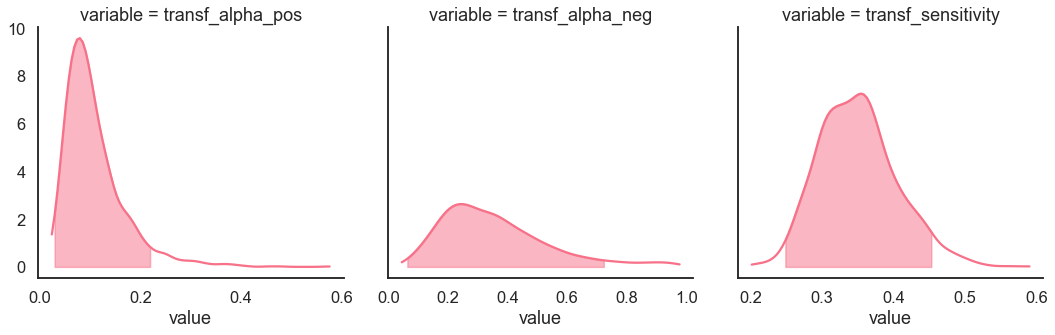

In [10]:
# With HDI
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

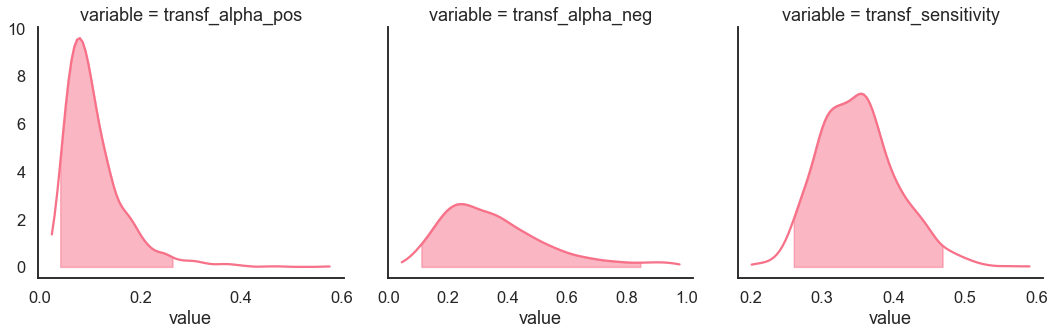

In [11]:
# With BCI
model_fit.plot_posteriors(height=5, show_intervals="BCI", alpha_intervals=.05);

## Posterior predictives

### Ungrouped

In [12]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=1000)
pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 231 232 233 234   
sample                                                 ...                   
1               1   0   1   1   1   1   1   0   0   0  ...   1   1   1   0   
2               0   0   1   1   1   1   1   1   0   0  ...   1   1   1   0   
3               0   0   1   1   1   1   1   0   0   1  ...   0   1   1   0   
4               0   1   0   0   1   1   1   1   0   1  ...   0   1   1   1   
5               0   0   1   1   0   1   1   1   0   1  ...   0   1   1   1   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
996             0   1   1   1   1   1   0   1   0   1  ...   1   1   1   1   
997             0   0   1   1   0   1   1   0   0   0  ...   1   1   1   1   
998             0   0   1   0   0   0   0   1   1   0  ...   0   1   1   1   
999             0   0   0   1   1   1   1   0   1   1  ...   1   1   1   1   
1000            0   0   1   1   1   0   0   1   1   1  ...   1   0   1   1   

variable                          
trial    235 236 237 238 239 240  
sample                            
1          1   1   1   0   1   1  
2          1   1   1   0   0   1  
3          1   1   1   0   1   1  
4          1   1   1   0   0   1  
5          1   0   1   0   1   1  
...       ..  ..  ..  ..  ..  ..  
996        1   1   1   0   1   1  
997        1   1   1   1   0   1  
998        1   1   1   1   1   1  
999        1   0   1   1   1   1  
1000       1   1   1   1   0   1  

[1000 rows x 240 columns]

In [13]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=1000)
pp_summary

,mean_accuracy
sample,
1,0.862500
2,0.875000
3,0.879167
4,0.833333
5,0.891667
...,...
996,0.829167
997,0.862500
998,0.858333


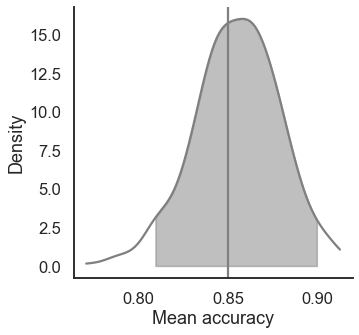

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

### Grouped

In [15]:
import numpy as np

In [16]:
# Define new grouping variables, in this case, for the different choice pairs, but any grouping var can do
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [17]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], 
                                                    n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1           1          AB          1            1.000000
                                   2            0.400000
                                   3            0.200000
                                   4            0.400000
                                   5            0.400000
...                                                  ...
3           8          CD          496          1.000000
                                   497          0.666667
                                   498          1.000000
                                   499          0.666667
                                   500          0.666667

[46000 rows x 1 columns]

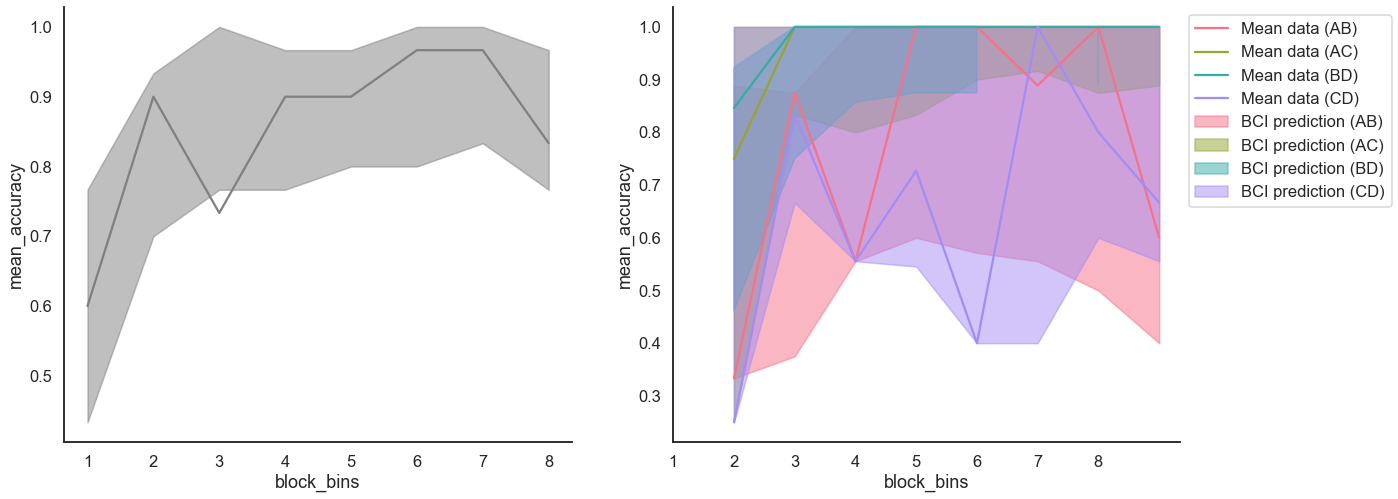

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()